# GHCNh false positive rate

## Load libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.ticker import MaxNLocator
import sys
ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
from GHCNh_lib import GHCNh # If GHCNh is was appended to path
from qaqc_eval_utils import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

## GHCNh dataset

### GHCNh test the convert to geopandas DataFrame

In [2]:
%%time
ghcnh = GHCNh(stations_local=True)
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))
ghcnh.station_data.head(3)

CAW00025343, -133.05000, 54.25000
CPU times: user 2.98 s, sys: 464 ms, total: 3.45 s
Wall time: 4.03 s


,Station_ID,Station_name,Year,Month,Day,Hour,Minute,Latitude,Longitude,Elevation,...,precipitation_24_hour_Source_Code,precipitation_24_hour_Source_Station_ID,remarks,remarks_Measurement_Code,remarks_Quality_Code,remarks_Report_Type,remarks_Source_Code,remarks_Source_Station_ID,time,geometry
0,CAW00025343,LANGARA,1954,1,1,9,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 09:00:00,POINT (-14811058.250 7217646.198)
1,CAW00025343,LANGARA,1954,1,1,21,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 21:00:00,POINT (-14811058.250 7217646.198)
2,CAW00025343,LANGARA,1954,1,2,3,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-02 03:00:00,POINT (-14811058.250 7217646.198)


## Train stations and even evaluation

### Read in stations

In [3]:
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')

### How to identify other events of interest using a start and end date

In [4]:
alt_start_date = "2007-10-20"
alt_end_date = "2007-10-24"
alt_event_stns = find_other_events (train_stns, event_start=alt_start_date, event_end=alt_end_date, buffer=14, subset=5)
alt_event_stns.head(3)

Subsetting station record for event duration with 14 day buffer...
5 stations selected for evaluation for comparison!
Stations selected for evaluation:
 ['ASOSAWOS_72488023185', 'CWOP_C3424', 'ASOSAWOS_72492023237', 'ASOSAWOS_72467793007', 'RAWS_NCKC2']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
65,ASOSAWOS,ASOSAWOS_72488023185,1342.6440,39.50800,-119.76800,1943-01-05 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
380,CWOP,CWOP_C3424,5001.0000,-111.30133,34.23367,2005-03-02 00:00:00+00:00,2014-04-04 22:14:00+00:00,NaN,NaN
66,ASOSAWOS,ASOSAWOS_72492023237,8.2296,37.89000,-121.22600,1941-01-03 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN


### Original functionality of `subset_eval_stns` function, random sampling from trainint stations

In [5]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    subset = 5,
    return_stn_ids = True
)
eval_stations.head(3)

17 potential stations available for evaluation for santa_ana_wind event.
5 stations selected for evaluation for santa_ana_wind event!
Stations selected for evaluation:
 ['ASOSAWOS_72292023191', 'ASOSAWOS_72290693112', 'ASOSAWOS_72381603159', 'ASOSAWOS_72382023182', 'CIMIS_75']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,STATEFP,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
2,ASOSAWOS,ASOSAWOS_72292023191,477.0120,33.404,-118.415,1943-06-12 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13181897.502 3949051.804)
9,ASOSAWOS,ASOSAWOS_72290693112,4.2672,32.692,-117.210,1945-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,41740,NaN,A,1.090437e+10,8.174046e+08,+33.0236041,-116.7761174,553042.602989,1.672201e+10,POINT (-13047757.516 3854493.112)
5,ASOSAWOS,ASOSAWOS_72381603159,712.6224,34.741,-118.213,1974-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13159410.965 4128739.545)


In [6]:
eval_stations['era-id'].values[-1]
# eval_stations.loc[eval_stations['era-id']==stn_id]

'CIMIS_75'

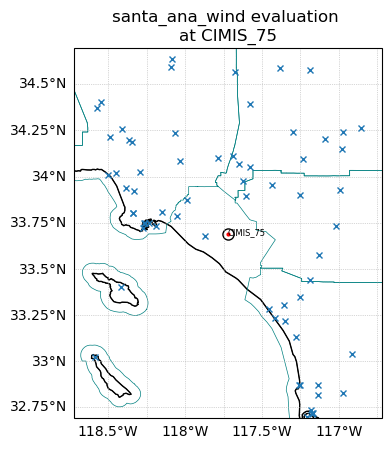

In [7]:
fig,ax = stn_visualize(
    stn_id = eval_stations['era-id'].values[-1],
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

ax.plot(ghcnh.stations_df.longitude, ghcnh.stations_df.latitude, 'x', markersize=4, transform=ccrs.PlateCarree(), mfc='none')

### New addition, specific station flag

<div style="width: 60%;">
Specific station flag introduced to control which station we are analyzing
Useful for debugging, down the line this would help to manage using the same
station and not download different stations every time in the nearest stations
part (down)
</div>

In [8]:
""" Test when station is not in the training/event dataframe"""

eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    specific_station='CIMIS_80',
    return_stn_ids = True
)
eval_stations

17 potential stations available for evaluation for santa_ana_wind event.


ValueError: Station CIMIS_80 is not within the training/event dataset

In [9]:
specific_station = 'CIMIS_45'
specific_station = 'CIMIS_75'

In [10]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    specific_station=specific_station,
    return_stn_ids = True
)
eval_stations

17 potential stations available for evaluation for santa_ana_wind event.


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,geometry
248,CIMIS,CIMIS_75,410.0,33.68845,-117.72118,1987-10-07 00:00:00+00:00,2024-01-22 13:36:19.951554+00:00,all,NaN,POINT (-13104661.813 3987044.797)


#### Plot 'specific station' from the training and the GHCNh stations in the 'area'

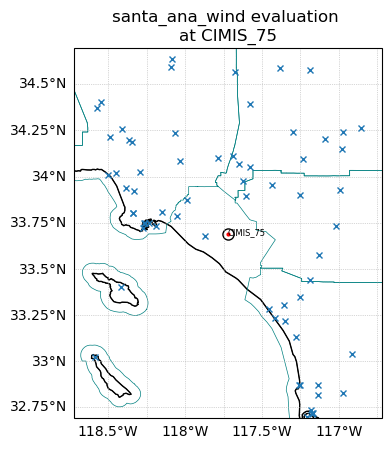

In [20]:
fig,ax = stn_visualize(
    stn_id = specific_station,
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

ax.plot(ghcnh.stations_df.longitude, ghcnh.stations_df.latitude, 'x', markersize=4, transform=ccrs.PlateCarree(), mfc='none')

## GHCNh stations distance to the testing stations

<div style="width: 60%;">
Create a distnace to specific station column for the ghcnh dataframe
Then, sort by distance to have the nearest stations to the one we are evaluating
</div>

### Create distance and sort it

In [12]:
stn_id = eval_stations['era-id'].values[-1]
point = eval_stations.loc[eval_stations['era-id']==stn_id].geometry.iloc[0]
ghcnh_stations_df = ghcnh.stations_df.copy()
display(eval_stations.loc[eval_stations['era-id']==stn_id, ["longitude","latitude"]])
ghcnh_stations_df['distance_to_eval'] = ghcnh_stations_df.distance(point, )
ghcnh_stations_df = ghcnh_stations_df.sort_values(by="distance_to_eval")
ghcnh_stations_df.head(5)

,longitude,latitude
248,-117.72118,33.68845


,id,latitude,longitude,elevation,state,name,gsn_flag,hcn,crn_flag,wmo_id,url,is_in_wecc,geometry,distance_to_eval
5627,USW00093184,33.6797,-117.8675,13.1,CA,SANTA ANA JOHN WAYNE AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13120950.081 3985874.222),16330.276109
5138,USW00053175,33.8978,-117.6025,162.5,CA,CORONA MUNICIPAL AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13091450.416 4015087.305),30998.762024
3575,USW00003166,33.8717,-117.9855,26.2,CA,FULLERTON MUNI AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13134085.781 4011587.454),38315.948053
5110,USW00053141,33.7900,-118.0519,10.7,CA,LOS ALAMITOS AAF,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13141477.395 4000638.892),39245.209887
3582,USW00003179,33.9756,-117.6250,193.9,CA,CHINO AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13093955.105 4025526.173),39943.083072


### Plot the closest 10 stations to the train/eval station

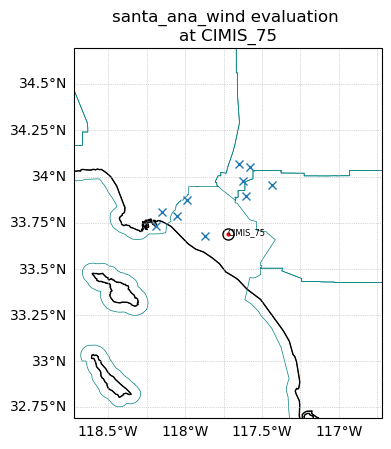

In [21]:
fig,ax = stn_visualize(
    stn_id = specific_station,
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

plot_df = ghcnh_stations_df.iloc[:10]
ax.plot(plot_df.longitude, plot_df.latitude, 'x', markersize=6, transform=ccrs.PlateCarree(), mfc='none');

In [22]:
def return_ghcn_vars(ghcn_df, input_var):
    '''
    Given an input variable, return GHCNh location variables and all relevant data variables,
    rather than utilizing the whole 240 cols, or having to know how ghcnh labels the cols.

    input_var must follow ERA naming scheme (tas, tdps, ps, pr, etc.)
    '''
    ghcnh_vars = pd.read_csv('ghcnh_data_headers.csv')

    # include station-ID, time, loc, elevation (cols 1-10)
    stn_info_cols = ['Station_ID', 'Station_name', 'time',
                     'Latitude','Longitude','Elevation',
                     'geometry'
                    ]
    vars = {
        'tas': 'temperature',
        'tdps': 'dew_point_temperature',
        'tdps_derived': 'dew_point_temperature',
        'ps': 'station_level_pressure',
        'psl': 'station_level_pressure',
        'sfcWind_dir': 'wind_direction',
        'sfcWind': 'wind_speed',
        'tas': 'temperature',
        'hurs': 'relative_humidity',
        'rsds': "N/A",
        'pr': 'precipitation',
        'pr_1h': 'precipitation',
        'pr_5min': 'precipitation',
    }
    if input_var in vars.keys():
        i = ghcn_df.columns.get_loc(vars[input_var])
        j = i+6
        # For wind, include wind gust
        if input_var=="sfcWind":
            j = j+6
        var_cols = ghcn_df.iloc[:, i:j].columns
        return_cols = np.concatenate([stn_info_cols,var_cols])
        
        return ghcn_df.loc[:, return_cols], vars
    else:
        raise Exception(f"Variable {input_var} not in variables' dictionary")

In [23]:
era2ghcn_vars

{'tas': 'temperature',
 'tdps': 'dew_point_temperature',
 'tdps_derived': 'dew_point_temperature',
 'ps': 'station_level_pressure',
 'psl': 'station_level_pressure',
 'sfcWind_dir': 'wind_direction',
 'sfcWind': 'wind_speed',
 'hurs': 'relative_humidity',
 'rsds': 'N/A',
 'pr': 'precipitation',
 'pr_1h': 'precipitation',
 'pr_5min': 'precipitation'}

In [17]:
# df, vars = return_ghcn_vars(ghcnh.station_data, 'tas')

In [ ]:
# len(df.temperature_Quality_Code.dropna())/len(df.temperature_Quality_Code)

In [18]:
%%time
ds = pull_nc_from_aws(specific_station) # manually retrieve a specific station
ds

Retrieving data for station...
CPU times: user 3.14 s, sys: 1.43 s, total: 4.57 s
Wall time: 34.6 s


<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) object 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 ...
    pr                    (station, time) float64 ...
    hurs                  (station, time) float64 ...
    rsds                  (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    tdps_derived_eraqc    (station, time) float64 ...
    pvp_derived_eraqc     (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

In [24]:
ds

<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) <U8 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 ...
    pr                    (station, time) float64 ...
    hurs                  (station, time) float64 ...
    rsds                  (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    tdps_derived_eraqc    (station, time) float64 ...
    pvp_derived_eraqc     (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

In [ ]:
%%time
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds)
df.head(3)

In [ ]:
ds.tas_eraqc.plot(marker=".", lw=0)

In [ ]:
df.tas_eraqc.plot(marker=".", lw=0)

In [ ]:
var = "hurs"
var = "tas"

print("\n{}".format(specific_station))
print(df.iloc[[0,-1]]['time'].values)
print(len(df[var+"_eraqc"].dropna())/len(df[var+"_eraqc"]))

for i in range(3):
    id = ghcnh_stations_df['id'].iloc[i]
    ghcnh.read_data_from_url(id, save=True)
    ghcnh.convert_df_to_gpd()
    tmp_df = ghcnh.station_data.copy()

    ghcnh_df, vars = return_ghcn_vars(tmp_df, var)
    print("=============================")
    print("{}".format(id))
    # print(ghcnh_df.iloc[[0,-1]].apply(lambda row: pd.Timestamp(row["Year"],row["Month"],row["Day"],row["Hour"]), axis=1).values)
    print(ghcnh_df.iloc[[0,-1]]['time'].values)
    print(len(ghcnh_df[vars[var]+'_Quality_Code'].dropna())/len(ghcnh_df[vars[var]+'_Quality_Code']))
    
    print()

In [ ]:
ghcnh_df[vars[var]+'_Quality_Code']

In [ ]:
ghcnh_df[vars[var]].plot()
ghcnh_df.dropna(subset=vars[var]+"_Quality_Code")[vars[var]].plot(marker=".", lw=0)

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
pd.DataFrame(ghcnh_df).iloc[5000:5200].plot(x="time",y="temperature",marker="x", lw=0, ax=ax)
pd.DataFrame(ghcnh_df).iloc[5000:5200].dropna(subset=vars[var]+"_Quality_Code").plot(x="time",y="temperature",marker="o", mfc="none", lw=0, ax=ax)

In [ ]:
len(ghcnh_df.dropna(subset=vars[var]+"_Quality_Code"))/len(ghcnh_df)

In [ ]:
print(len(ghcnh_df[vars[var]+'_Quality_Code'].dropna())/len(ghcnh_df[vars[var]+'_Quality_Code']))

In [ ]:
ghcnh_df[vars[var]+'_Quality_Code'].unique()

In [ ]:
np.setdiff1d(ghcnh_df[vars[var]+'_Quality_Code'].dropna().index, ghcnh_df.index)

In [ ]:
ind = pd.isna(ghcnh_df[vars[var]+'_Quality_Code'])
len(np.where(ind)[0])
len(plot_df[ind])

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
            ax=ax, marker=".", lw=0.5, color="black",
            markersize=2)
ax.fill_between(x=plot_df[ind].time, y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], color='skyblue', alpha=0.5)
# plot_df = plot_df[ind]
# plot_df.plot(x="time", y=vars[var], 
#              ax=ax, marker="o", lw=0.0, color="red",
#              markersize=4, label='Streaks', mfc='none')

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
                            ax=ax, marker=".", lw=0.5, color="black",
                            markersize=2)
plot_df = plot_df[plot_df[vars[var]+'_Quality_Code']=='K']
plot_df.plot(x="time", y=vars[var], 
             ax=ax, marker="o", lw=0.0, color="red",
             markersize=4, label='Streaks', mfc='none')

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
                            ax=ax, marker=".", lw=0.5, color="black",
                            markersize=2)
plot_df = plot_df[plot_df[vars[var]+'_Quality_Code']=='K']
plot_df.plot(x="time", y=vars[var], 
             ax=ax, marker="o", lw=0.0, color="red",
             markersize=4, label='Streaks', mfc='none')
ax.set_xlim(np.datetime64("2003-03-08"),np.datetime64("2003-03-23"))

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
                            ax=ax, marker=".", lw=0.5, color="black",
                            markersize=2)
plot_df = plot_df[plot_df[vars[var]+'_Quality_Code']=='o']
plot_df.plot(x="time", y=vars[var], 
             ax=ax, marker="o", lw=0.0, color="red",
             markersize=4, label='Out of range', mfc='none')

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
plot_df = pd.DataFrame(ghcnh_df)
plot_df.plot(x="time", y=vars[var], 
                            ax=ax, marker=".", lw=0.5, color="black",
                            markersize=2)
plot_df = plot_df[plot_df[vars[var]+'_Quality_Code']=='f']
plot_df.plot(x="time", y=vars[var], 
             ax=ax, marker="x", lw=0.0, color="red",
             markersize=4, label='Suspect or Error', mfc='none')

In [ ]:
ghcnh_df.columns

In [ ]:
ghcnh_df['relative_humidity_Measurement_Code'].unique()

In [ ]:
ghcnh_df['relative_humidity_Quality_Code'].unique()

In [ ]:
ghcnh_df['relative_humidity_Report_Type'].unique()

In [ ]:
ghcnh_df['relative_humidity_Source_Code'].unique()

In [ ]:
ghcnh_df['relative_humidity_Source_Station_ID'].unique()

In [ ]:
# df[var+"_eraqc"]

In [ ]:
df.dropna(subset=vars["tas"])

In [ ]:
len(df.temperature_Quality_Code.dropna())/len(df.temperature_Quality_Code)

- ERA5 map
- Accumulated flags
- Interpolated stations or mean


In [ ]:
ghcnh.convert_df_to_gpd(ghcnh.station_data)